# HW3

### Random Data Generator

- univariate gaussian data

- polynomial basis linear model

### Sqeuential estimate the mean and variance

### Baysian Linear regression

In [12]:
import math
import random
import matplotlib.pyplot as plt

In [30]:
def Mean(x):
    return sum(x) / len(x)

def Variance(x):
    u = Mean(x)
    return sum([(i - u)**2 for i in x]) / len(x)
    
def Covariance(x, y):
    ux = Mean(x)
    uy = Mean(y)
    return sum([(x[i] - ux)*(y[i] - uy) for i in range(len(x))]) / len(x)

### Random Data Generator

#### univariate gaussian data

- INPUT : expectation value $u$, variance $\sigma^2$
- OUTPUT : one outcome

all outcome will distribute like $N(u,\sigma^2)$

##### Marsaglia polar method

$$ \\
-1 \underline{<} U , V \underline{<} 1, S = U^2+V^2 \\
X = U\sqrt{\frac{-2\ln S}{S}}, Y = V\sqrt{\frac{-2\ln S}{S}}, when \space S < 1
$$

In [160]:
def Marsaglia():
    while True:
        U = random.random()*2-1
        V = random.random()*2-1
        if (U**2)+(V**2) < 1:
            break
    
    S = (U**2)+(V**2)
    S = math.sqrt((-2*math.log(S))/S)
    return (U*S, V*S)

def GaussianDataGenerator(u, v):
    sigma = math.sqrt(v)
    while True:
        D1, D2 = Marsaglia()
        yield u + sigma*D1
        yield u + sigma*D2

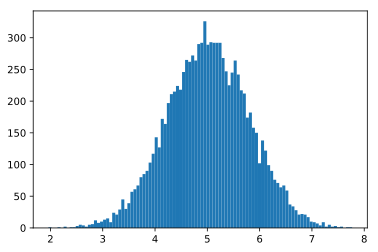

[5.016777706249596, 0.6156058875691389]

In [66]:
GDG = GaussianDataGenerator(5, 0.6)

Gdatas = [next(GDG) for _ in range(10000)]

plt.hist(Gdatas, 100)
plt.show()
[Mean(Gdatas), Variance(Gdatas)]

#### polynomial basis linear model

$$ y=w^TPhi(x)+e;e \sim N(0,\sigma^2) \\
w^TPhi(x) = \sum_{i}^{n} w_ix^i
$$

- INPUT : error variance $\sigma^2$, weight $w$,basis number $n$ for $Phi(x)$
- OUTPUT : one data point $(x,y)$
- NOTE : $ -10.0 < x < 10.0 $

In [163]:
def Gaussian(u, v):
    return lambda x : (math.exp(-1*(((x - u)**2) / (2*v) ) ) / math.sqrt(2*math.pi*v))

def Polynomial(w):
    return lambda x : sum([w[i]*(x**i) for i in range(len(w))])

def PolynomialDataGenerator(n, v, w):
    if len(w) != n:
        raise TypeError("length of w need equal n, {}!={}".format(len(w), n))
    e = GaussianDataGenerator(u=0,v=v)
    phi = Polynomial(w)
    while True:
        x = random.random()*20 - 10
        y = phi(x) + next(e)
        yield (x, y)

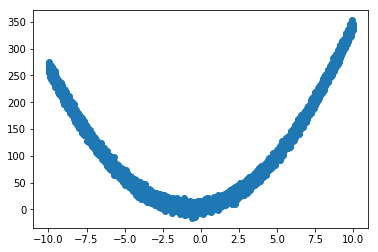

In [166]:
dg = PolynomialDataGenerator(3, 25, [5, 4, 3])
tmp = [next(dg) for _ in range(10000)]
x = [item[0] for item in tmp]
y = [item[1] for item in tmp]

plt.scatter(x, y)
plt.show()

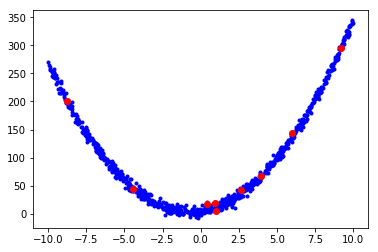

CPU times: user 30.7 s, sys: 22.5 s, total: 53.2 s
Wall time: 18.1 s


In [178]:
%%time
from IPython.display import clear_output
import time 
dg = PolynomialDataGenerator(n=3,v=10000,w=[0,1,0.01])
point_count = 1000
show_per_count = 10
data_x = []
data_y = []
show_x = []
show_y = []
for datapoint in tmp:
    x, y = datapoint
    
    if point_count % show_per_count == 0:
        plt.plot(data_x, data_y, 'b.')
        plt.plot(show_x, show_y, 'ro')
        plt.show()
        #time.sleep(0.5)
        data_x += show_x
        show_x = []
        data_y += show_y
        show_y = []
    else:
        show_x.append(x)
        show_y.append(y)
    
    point_count -= 1
    if point_count == 0:
        break;
    if point_count % show_per_count == 0:
        clear_output(wait=True)

### Sqeuential estimate the mean and variance

- INPUT : expectation value $u$, variance $\sigma^2$
- FUNCTION : find cureent estimates, repeat until the estimates converge
- OUTPUT : print new data point and cureent estimates each iteration

In [160]:
def NaiveEstimate():
    u = 0
    v = 1
    n = 0
    data_sum = 0
    data_sum2 = 0
    while True:
        new_data = (yield (u, v))
        n += 1
        data_sum += new_data
        data_sum2 += new_data**2
        u = data_sum / n
        v = (data_sum2 / n) - (u**2)

def SqeuentialEstimate(u, v, es=NaiveEstimate):
    current_u = 0
    current_v = 1
    dg = GaussianDataGenerator(u, v)
    es = es()
    current_u, current_v = next(es)
    converge_threshold = 10**-2
    while True:
        new_data = next(dg)
        current_u, current_v = es.send(new_data)
        yield (new_data, current_u, current_v, u, v)
        if (abs(u - current_u) < converge_threshold and abs(v - current_v) < converge_threshold):
            break

In [143]:
def test_SqeuentialEstimate(u, v, times=1, max_iter=10000, output=False, output_rate = 1):
    iter_counts = []
    
    while times != 0:
        iter_count = 0
        se = SqeuentialEstimate(u, v)
        
        if output:
            print("\n"+"="*10+"Test Start"+"="*10+"\n")
        
        for estimate in se:
            iter_count += 1
            if output and (iter_count-1) % output_rate == 0:
                print("[{:5d}] new data : {:.3f}\tcurrent(u,v):({:.3f}, {:.3f})\ttarget(u,v):({:.3f}, {:.3f})".format(
                    iter_count,
                    estimate[0],
                    estimate[1],
                    estimate[2],
                    estimate[3],
                    estimate[4],))
            if iter_count > max_iter and max_iter != -1:
                break;
        
        if output:
            print("\n"+"="*10+"Test   End"+"="*10+"\n")
        iter_counts.append(iter_count)
        
        times -= 1
        
    return iter_counts

In [163]:
test_SqeuentialEstimate(5, 0.6, output=True, output_rate=10)


==========Test Start==========

[    1] new data : 5.305	current(u,v):(5.305, 0.000)	target(u,v):(5.000, 0.600)
[   11] new data : 3.646	current(u,v):(4.848, 1.349)	target(u,v):(5.000, 0.600)
[   21] new data : 5.276	current(u,v):(5.085, 0.893)	target(u,v):(5.000, 0.600)
[   31] new data : 4.729	current(u,v):(4.821, 0.919)	target(u,v):(5.000, 0.600)
[   41] new data : 5.324	current(u,v):(4.844, 0.763)	target(u,v):(5.000, 0.600)
[   51] new data : 3.877	current(u,v):(4.952, 0.806)	target(u,v):(5.000, 0.600)
[   61] new data : 4.466	current(u,v):(4.961, 0.744)	target(u,v):(5.000, 0.600)
[   71] new data : 5.041	current(u,v):(4.959, 0.820)	target(u,v):(5.000, 0.600)
[   81] new data : 3.785	current(u,v):(4.946, 0.794)	target(u,v):(5.000, 0.600)
[   91] new data : 5.069	current(u,v):(4.932, 0.770)	target(u,v):(5.000, 0.600)
[  101] new data : 5.337	current(u,v):(4.928, 0.790)	target(u,v):(5.000, 0.600)
[  111] new data : 4.381	current(u,v):(4.922, 0.790)	target(u,v):(5.000, 0.600)
[  121]

[2752]

In [164]:
%%time
test_outputs = test_SqeuentialEstimate(5, 0.6, times=10000)

CPU times: user 34.9 s, sys: 52.6 ms, total: 35 s
Wall time: 35 s


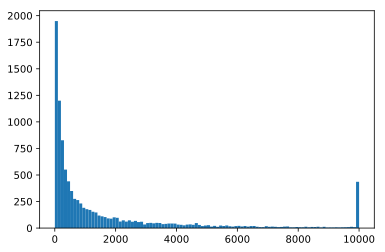

In [165]:
plt.hist(test_outputs, 100)
plt.show()

### Baysian Linear regression

- INPUT : for inital prior $\sim N(0, b^{-1}I)$ parameter $b$, error variance $\sigma^2$, weight $w$,basis number $n$ for $Phi(x)$
- FUNCTION : gen one data point and update prior and calculate the predictive distribution, repeat until the posterior converges
- OUTPUT : print the new data point and the current parameter for posterior and predictive distribution

$$\\
k : datapoints \space numbers \\
S^{-1} : prior \space covariance \space matrix , n*n\\
m : prior \space mean \space vector, n*1\\
X : design \space matrix, k*n \\
y_{pred} = Xw + error, k*1 \\
posterior_b = aX^TX + S = aX^TX + prior_b\\
w = posterior_u = posterior_b^{-1}(aX^Ty + Sm) = posterior_b^{-1}(aX^Ty + (prior_b)(prior_u)) \\
$$

In [113]:
from MatrixOP import *
from Polynomial import *
from IPython.display import Latex, Markdown, Pretty
import pandas as pd
import numpy as np

In [20]:
def Design_Matrix(datas, N):
    # create matrix
    Design_X = [];
    Target_y = [];
    
    if type(datas) != list:
        datas = [datas]

    for index, row in enumerate(datas):
        x,y = row
        Design_X.append([basis(x, i) for i in range(N)])
        Target_y.append([y])
    
    return (Design_X,Target_y)

In [139]:
def BaysianLinearRegression(dataGenerator, likelihood_a, prior_u, prior_b):
    n = len(prior_u)
    input_u = prior_u
    input_b = prior_b
    
    
    while True:
        new_data = next(dataGenerator)
        X,y = Design_Matrix(new_data,n)
        
        # b' = aX^TX + b
        posterior_b = mul_matrix_scalar(likelihood_a, mul_matrix(tranpose_matrix(X), X))
        posterior_b = add_matrix(posterior_b, prior_b)
        # u' = b'^-1(aX^Ty + bu)
        posterior_u = add_matrix(mul_matrix_scalar(likelihood_a ,mul_matrix(tranpose_matrix(X), y)), mul_matrix(prior_b, prior_u))
        posterior_u = mul_matrix(inverse_matrix(posterior_b), posterior_u)
        
        reset = yield (new_data, posterior_u, posterior_b)

        if reset == True:
            prior_u = input_u
            prior_b = input_b
            yield (prior_u, prior_b)
        else:
            prior_u = posterior_u
            prior_b = posterior_b

In [141]:
class mylogging():
    def __init__(self, output=False):
        self.logs = ""
        self.output = output
    
    def info(self, s):
        if self.output:
            print(s)
        self.logs += s + "\n"
    
def test_BaysianLinearRegression(BLR, converge_threshold=10**-3, times=1, max_iter=10000, output=False, output_rate = 1):
    iter_counts = []
    mylog = mylogging(output)
    
    while times != 0:
        iter_count = 0
        
        # reset BLR
        next(BLR)
        prev_u, prev_b = BLR.send(True)
    
        mylog.info("\n"+"="*10+"Test Start"+"="*10+"\n")
        
        for regression in BLR:
            iter_count += 1
            x,y = regression[0]
            u = regression[1]
            b = regression[2]
            predict = polynomial_equation(u)
            if (iter_count-1) % output_rate == 0:
                mylog.info("[{:5d}] new data(x,y) : ({:.3f}, {:.3f})".format(iter_count, x, y))
                mylog.info("\n predictive distribution : " + str(predict) + "\n")
                
            # converge check
            All_converge = True
            distance_u = sub_matrix(u, prev_u)
            distance_b = sub_matrix(b, prev_b)
            for rows in distance_u:
                for item in rows:
                    if abs(item) > converge_threshold:
                        All_converge = False
                        break;
                
                if not All_converge:
                    break;
                
            if All_converge:
                break;
                
            if iter_count >= max_iter and max_iter != -1:
                break;
                
            prev_u = u;
            prev_b = b;
        
        mylog.info("\n"+"="*10+"Test   End"+"="*10+"\n")
        iter_counts.append(iter_count)
        
        times -= 1
        
    return (iter_counts, mylog.logs)

In [143]:
# input parameter
error_v = 5
w = [3, 0.05, 0.01]
n = 3

# n*n
prior_b = tranpose_matrix(unit_matrix(n=n))
# n*1
prior_u = [[0] for _ in range(n)]
# likelihood gaussian variance
likelihood_a = 1

dg = PolynomialDataGenerator(n, error_v, w)
blr = BaysianLinearRegression(dg, 1, prior_u, prior_b)

In [145]:
outcomes, logs = test_BaysianLinearRegression(blr, converge_threshold=10**-5,times=1, max_iter=100)
print(outcomes)
Markdown(logs)

[62]



==========Test Start==========

[    1] new data(x,y) : (5.765, 3.627)

 predictive distribution : $$y = +0.11x^2+0.02x^1+0.00$$

[    2] new data(x,y) : (-5.859, 3.056)

 predictive distribution : $$y = +0.10x^2+0.06x^1+0.00$$

[    3] new data(x,y) : (7.226, 3.884)

 predictive distribution : $$y = +0.08x^2+0.00x^1+0.29$$

[    4] new data(x,y) : (6.913, 3.825)

 predictive distribution : $$y = +0.08x^2-0.00x^1+0.30$$

[    5] new data(x,y) : (2.903, 3.306)

 predictive distribution : $$y = +0.05x^2+0.05x^1+1.36$$

[    6] new data(x,y) : (-7.482, 3.186)

 predictive distribution : $$y = +0.04x^2+0.07x^1+1.40$$

[    7] new data(x,y) : (-8.475, 3.295)

 predictive distribution : $$y = +0.04x^2+0.09x^1+1.49$$

[    8] new data(x,y) : (5.490, 3.585)

 predictive distribution : $$y = +0.04x^2+0.09x^1+1.54$$

[    9] new data(x,y) : (5.208, 3.544)

 predictive distribution : $$y = +0.04x^2+0.10x^1+1.60$$

[   10] new data(x,y) : (2.532, 3.285)

 predictive distribution : $$y = +0.03x^2+0.09x^1+1.94$$

[   11] new data(x,y) : (-7.754, 3.214)

 predictive distribution : $$y = +0.03x^2+0.09x^1+1.94$$

[   12] new data(x,y) : (7.347, 3.908)

 predictive distribution : $$y = +0.03x^2+0.08x^1+1.99$$

[   13] new data(x,y) : (7.201, 3.880)

 predictive distribution : $$y = +0.03x^2+0.08x^1+2.01$$

[   14] new data(x,y) : (-9.169, 3.382)

 predictive distribution : $$y = +0.03x^2+0.08x^1+2.05$$

[   15] new data(x,y) : (0.564, 3.204)

 predictive distribution : $$y = +0.02x^2+0.07x^1+2.32$$

[   16] new data(x,y) : (2.859, 3.303)

 predictive distribution : $$y = +0.02x^2+0.07x^1+2.42$$

[   17] new data(x,y) : (-0.681, 3.141)

 predictive distribution : $$y = +0.02x^2+0.07x^1+2.56$$

[   18] new data(x,y) : (-6.893, 3.132)

 predictive distribution : $$y = +0.02x^2+0.07x^1+2.56$$

[   19] new data(x,y) : (7.127, 3.865)

 predictive distribution : $$y = +0.02x^2+0.06x^1+2.57$$

[   20] new data(x,y) : (4.112, 3.408)

 predictive distribution : $$y = +0.02x^2+0.07x^1+2.59$$

[   21] new data(x,y) : (0.345, 3.195)

 predictive distribution : $$y = +0.02x^2+0.06x^1+2.67$$

[   22] new data(x,y) : (-2.090, 3.054)

 predictive distribution : $$y = +0.02x^2+0.06x^1+2.73$$

[   23] new data(x,y) : (-8.436, 3.290)

 predictive distribution : $$y = +0.02x^2+0.06x^1+2.73$$

[   24] new data(x,y) : (-9.369, 3.409)

 predictive distribution : $$y = +0.02x^2+0.06x^1+2.73$$

[   25] new data(x,y) : (-6.527, 3.102)

 predictive distribution : $$y = +0.02x^2+0.06x^1+2.74$$

[   26] new data(x,y) : (5.736, 3.622)

 predictive distribution : $$y = +0.02x^2+0.06x^1+2.74$$

[   27] new data(x,y) : (1.648, 3.246)

 predictive distribution : $$y = +0.01x^2+0.06x^1+2.78$$

[   28] new data(x,y) : (-1.992, 3.060)

 predictive distribution : $$y = +0.01x^2+0.06x^1+2.81$$

[   29] new data(x,y) : (-1.167, 3.111)

 predictive distribution : $$y = +0.01x^2+0.06x^1+2.84$$

[   30] new data(x,y) : (8.637, 4.178)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.85$$

[   31] new data(x,y) : (4.272, 3.425)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.85$$

[   32] new data(x,y) : (3.798, 3.376)

 predictive distribution : $$y = +0.01x^2+0.06x^1+2.86$$

[   33] new data(x,y) : (-3.796, 2.997)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.87$$

[   34] new data(x,y) : (-1.950, 3.063)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.89$$

[   35] new data(x,y) : (6.033, 3.670)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.89$$

[   36] new data(x,y) : (7.448, 3.928)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.89$$

[   37] new data(x,y) : (4.533, 3.455)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.89$$

[   38] new data(x,y) : (-1.459, 3.093)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.91$$

[   39] new data(x,y) : (-9.101, 3.373)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.91$$

[   40] new data(x,y) : (-8.218, 3.265)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.91$$

[   41] new data(x,y) : (5.906, 3.650)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.91$$

[   42] new data(x,y) : (-7.096, 3.150)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.91$$

[   43] new data(x,y) : (-2.378, 3.039)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.92$$

[   44] new data(x,y) : (-2.857, 3.018)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.93$$

[   45] new data(x,y) : (8.278, 4.099)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.93$$

[   46] new data(x,y) : (9.084, 4.279)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.93$$

[   47] new data(x,y) : (6.437, 3.739)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.93$$

[   48] new data(x,y) : (7.154, 3.870)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.93$$

[   49] new data(x,y) : (-9.761, 3.465)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.93$$

[   50] new data(x,y) : (-9.969, 3.495)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.93$$

[   51] new data(x,y) : (3.003, 3.313)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.94$$

[   52] new data(x,y) : (5.590, 3.600)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.94$$

[   53] new data(x,y) : (5.920, 3.652)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.94$$

[   54] new data(x,y) : (9.537, 4.386)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.94$$

[   55] new data(x,y) : (-3.362, 3.003)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.95$$

[   56] new data(x,y) : (0.742, 3.211)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.96$$

[   57] new data(x,y) : (9.079, 4.278)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.96$$

[   58] new data(x,y) : (1.254, 3.231)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.97$$

[   59] new data(x,y) : (-4.498, 3.001)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.97$$

[   60] new data(x,y) : (0.125, 3.185)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.98$$

[   61] new data(x,y) : (-6.301, 3.085)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.98$$

[   62] new data(x,y) : (6.890, 3.821)

 predictive distribution : $$y = +0.01x^2+0.05x^1+2.98$$


==========Test   End==========



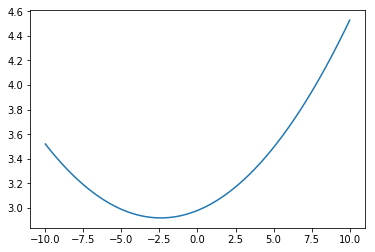

$$y = +0.01x^2+0.05x^1+2.98$$

In [146]:
_, predict_w, _ = next(blr) 
predict_distribution = polynomial_equation(predict_w)
x = np.linspace(-10,10,1000)
plt.plot(x, [predict_distribution.f(i) for i in x])
plt.show()
Markdown(str(predict_distribution))